This example was taken from the book **The Essence of Chaos** by *Edward Lorenz*. The aim of the model he presented in that chapter is to show how we can construct parsimonious models from real case phenomenons that exhibit chaos. 

The model consists of a board that goes down a regularly-bumpy slope or moguls without any control of the direction whatsoever. The dynamical system of this board is described by the system of ODE shown bellow

$$\frac{dx}{dt} = U, \quad \frac{dx}{dt} = V, \quad \frac{dz}{dt} = W.$$

\begin{align}
\frac{du}{dt} &= -F \partial_x H - cu, \\
\frac{dv}{dt} &= -F \partial_y H - cv, \\
\frac{dw}{dt} &= -g + F - cw.
\end{align}

\begin{align}
\frac{d \vec{u}}{dt} &= -F \nabla_H H - c \vec{u}.\\
\end{align}


$\vec{x} = (x,y,z)$ are the spacial coordinates and $\vec{u} = (u,v,w)$ are the components of the velocity of the board. And $H$ is the shape pf the slope that is parameterized by the following expression: 

$$H(x,y) = -ax - b \ cos(px) \ cos(qy).$$

In [504]:
using Plots
using LaTeXStrings

In [451]:
a = 0.25
b = 0.5
q = (2π)/4.0
p = (2π)/10.0

slope_parametrization(x,y) = -a*x .- b*cos(p*x).*cos(q*y)

slope_parametrization (generic function with 1 method)

In [452]:
function generate_slope(G::Function, xx_range, yy_range)
    
    slope = zeros(length(x_range), length(y_range))
    
    for i in 1:length(xx_range)
        for j in 1:length(xx_range)
            
            slope[i,j] = G(xx_range[i], yy_range[j])
            
        end
    end
    
    slope
    
end

generate_slope (generic function with 1 method)


**WARNING! The surface plot takes too long. Avoid it if you are in a rush.**


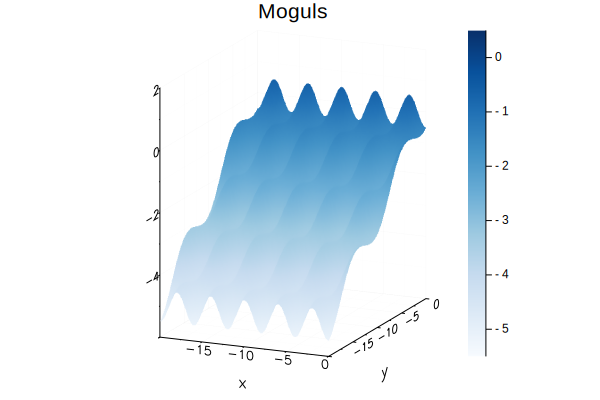

In [511]:
gr()
x_range = 0:0.2:20
y_range = 0:0.2:20
sol = generate_slope(slope_parametrization, x_range, y_range)

surface(-x_range, -y_range, sol, color=:Blues)
xlabel!("x")
ylabel!("y")
title!("Moguls")

# Boards down the slope!

Our first goal is to solve the ODE system for a given initial condition using a numerical integration method. For this, we declare a function containing the right-hand side terms of the ODE system that we want to solve. 

In [76]:
function board(X_0::Array, b::Float64)
    
    x0 = copy(X_0[1])
    y0 = copy(X_0[2])
    u0 = copy(X_0[3])
    v0 = copy(X_0[4])
    
    g = 9.81
    c = 0.5
    a = 0.25
    p = (2*π)/10.0
    q = (2*π)/4.0
    
    H = -a*x0 - b*cos(p*x0)*cos(q*y0) 
    H_x = -a + b*p*sin(p*x0)*cos(q*y0)
    H_xx = b*p^2 * cos(p*x0)*cos(q*y0)
    H_y = b*q*cos(p*x0)*sin(q*y0)
    H_yy = b*q^2 * cos(p*x0)*cos(q*y0)
    H_xy = -b*q*p*sin(p*x0)*sin(q*y0)
        
    F = (g + H_xx*u0^2 + 2*H_xy*u0*v0 + H_yy*v0^2)/(1 + H_x^2 + H_y^2)
    
    dU = -F*H_x - c*u0
    dV = -F*H_y - c*v0
    
    return [u0, v0, dU, dV]
    
end

board (generic function with 2 methods)

We use the fourth-order **Runge-Kutta method** as an integrator and we wrap it around the `solver` function. 

In [454]:
function runge_kutta_step(f::Function, x0, dt::Float64, t=nothing)
       
    k1 = f(x0, t) * dt
    k2 = f(x0 + k1/2, t) * dt
    k3 = f(x0 + k2/2, t) * dt
    k4 = f(x0 + k3, t) * dt
    x_new = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return x_new
end

runge_kutta_step (generic function with 5 methods)

In [ ]:
function solver(f::Function, x0::Array, y0::Array, v0::Array, u0::Array, dt::Float64, N_t::Int, N::Int, b = 0.5)
    
    solution = zeros(4, N_t+1, N)
    solution[1, 1, :] = x0
    solution[2, 1, :] = y0
    solution[3, 1, :] = u0
    solution[4, 1, :] = v0
    
    for i in 2:N_t + 1
        for k in 1:N
            
            x_0_step = solution[:, i-1, k]
            solution[:, i, k] = runge_kutta_step(f, x_0_step, dt, b)
        end
    end
         
    return solution
end

So now that we have our solver we can crush some snow with our boards in the moguls! 

In [497]:
n_sleds = 10
n_time = 1000
x_init = zeros(n_sleds)
y_init = rand(n_sleds)
v_init = zeros(n_sleds)
u_init = zeros(n_sleds) .+ 3.5

sol_not_compact = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds);

In [498]:
function plot_several_position(A, N)
    
    plot(A[2,:,1], A[1,:,1], yflip=true, size =(300, 600), leg = false, border = :box)
    xlabel!("y (m)")
    ylabel!("x (m)")
    for i in 2:N
        plot!(A[2,:,i], A[1,:,i])
    end
    plot!()
end

plot_several_position (generic function with 1 method)

### Example 1

Initial conditions: $x = 0.0$, $y = [0,1]$ (randomly choosen), $U = 3.5$ and $V = 0$.

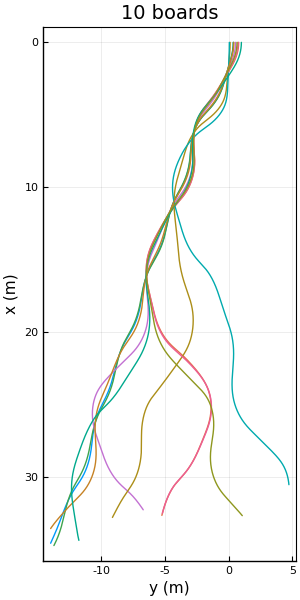

In [513]:
pyplot()
plot_several_position(sol_not_compact, n_sleds)
title!("10 boards")

### Example 2

Initial conditions: $x = 0.0$, $y = [0,1]$ scatterd evenly, $U = 4.0$ and $V = 2.0$.

In [495]:
n_sleds = 11
n_time = 1000
x_init = zeros(n_sleds)
y_init = collect(0:0.1:1)
v_init = zeros(n_sleds) .+ 2.0 #zeros(n_sleds)
u_init = zeros(n_sleds) .+ 4.0

sol_not_compact = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds);

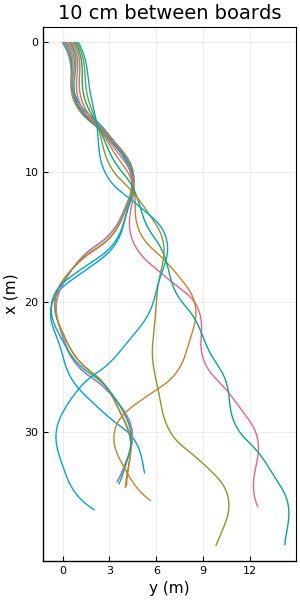

In [496]:
pyplot()
plot_several_position(sol_not_compact, n_sleds)
title!("10 cm between boards")

We can see how the system behaves chaotically, i.e if we vary a little the initial conditions, the trajectories of the boards diverge after 10 m downslope.

### Example 3
Initial conditions just spaced $1$mm apart from $0.497$m to $0.503$m.

In [490]:
y_init = collect(0.497:0.001:0.503)
n_sleds = length(y_init)

n_time = 2200
x_init = zeros(n_sleds)
v_init = zeros(n_sleds) .+ 2.0 #zeros(n_sleds)
u_init = zeros(n_sleds) .+ 4.0

sol_not_compact = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds);

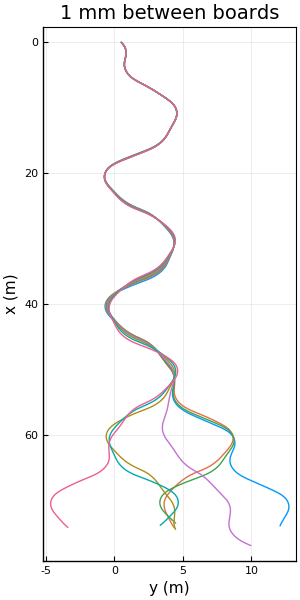

In [493]:
pyplot()
plot_several_position(sol_not_compact, n_sleds)
title!("1 mm between boards")

The above shows that the system is sensitive to initial conditions but we would like to explore further the dynamics of the system. One of the technique for exploring the dynamics of the system is by plotting the phase space and see how the system behaves. The only problem is that for this system, there are 4 variables, which means that the phase space of the system lives in a four-dimensional space, which is not possible for us to visualize. We need to do some modifications to our board to reduce the dimensions of our system.


# Sleds down the slope!



In [3]:
function sled(b::Float64, X_0::Array)
    
    x0 = copy(X_0[1])
    y0 = copy(X_0[2])
    u0 = copy(X_0[3])
    v0 = copy(X_0[4])
    
    g = 9.81
    c = 0.5
    a = 0.25
    p = (2*π)/10.0
    q = (2*π)/4.0
    
    H = -a*x0 - b*cos(p*x0)*cos(q*y0) 
    H_x = -a + b*p*sin(p*x0)*cos(q*y0)
    H_xx = b*p^2 * cos(p*x0)*cos(q*y0)
    H_y = b*q*cos(p*x0)*sin(q*y0)
    H_yy = b*q^2 * cos(p*x0)*cos(q*y0)
    H_xy = -b*q*p*sin(p*x0)*sin(q*y0)
        
    F = (g + H_xx*u0^2 + 2*H_xy*u0*v0 + H_yy*v0^2)/(1 + H_x^2 + H_y^2)
    
    dU = 0
    dV = -F*H_y - c*v0
    
    return [u0, v0, dU, dV]
    
end

sled (generic function with 1 method)

# Sleds and stange attractors

In [63]:
function solver_compact(f::Function, x0::Array, y0::Array, v0::Array, u0::Float64, dt::Float64, N_t::Int, N::Int, b = 0.5)
    
    solution = zeros(3, N_t+1, N)
    solution[1, 1, :] = x0
    solution[2, 1, :] = y0
    solution[3, 1, :] = v0
    
    for i in 2:N_t+1
        for k in 1:N
            
            x_0_step = insert!(solution[:, i-1, k], 3, u0)
            
            aux = runge_kutta_step(f, x_0_step, dt, b)
            solution[1, i, k] = compactor(aux[1], -5, 5)
            solution[2, i, k] = compactor(aux[2], -2, 2)
            solution[3, i, k] = aux[4]
        
        end   
    end

    return solution
end

solver (generic function with 4 methods)

In [2]:
function compactor(x, lower_bound, upper_bound)
    
    if x > upper_bound
        return x%upper_bound - upper_bound
        
    elseif x < lower_bound 
        return x%lower_bound - lower_bound
        
    else
        return x
        
    end
end

compactor (generic function with 1 method)

In [93]:
n_sleds = 1000
n_time = 1500
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds).*10 .- 5

@time sol_compact = solver_compact(sled, x_init, y_init, v_init, 3.5, 0.01, n_time, n_sleds);

 26.172413 seconds (99.00 M allocations: 4.839 GiB, 3.70% gc time)


![](https://i.kym-cdn.com/photos/images/original/000/284/529/e65.gif)

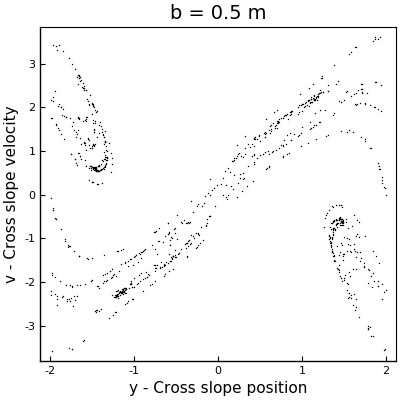

In [514]:
st = 1000
scatter(sol_compact[2, st, :], sol_compact[3, st, :], markersize = 1, legend=false, 
    markercolor= :black, grid = false, size =(400, 400), 
    markerstrokewidth=0, border = :box)

xlabel!("y - Cross slope position")
ylabel!("v - Cross slope velocity")
title!("b = 0.5 m")

## "Optimaized" function

In [96]:
dV(v0, F, H_y, c) = -F*H_y - c*v0 

function runge_kutta_step_2(f::Function, x0, dt, F, H, c)
       
    k1 = f(x0, F, H, c) * dt
    k2 = f(x0 + k1/2, F, H, c) * dt
    k3 = f(x0 + k2/2, F, H, c) * dt
    k4 = f(x0 + k3, F, H, c) * dt
    x_new = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return x_new
end

function sled_enssemble(x0::Array, y0::Array, v0::Array, u0::Float64 , n::Int, dt::Float64, N::Int, b = 0.5)
    g = 9.81
    c = 0.5
    a = 0.25
    p = (2π)/10.0
    q = (2π)/4.0
   
    x_sol = zeros(N, n+1)
    y_sol = zeros(N, n+1)
    v_sol = zeros(N, n+1)
    
    x_sol[:, 1] = x0
    y_sol[:, 1] = y0
    v_sol[:, 1] = v0
    
    for i in 1:n
        for k in 1:N
                
            x_i = x_sol[k, i]
            y_i = y_sol[k, i]
            v_i = v_sol[k, i]

            H = -a*x_i - b*cos(p*x_i)*cos(q*y_i) 
            H_x = -a + b*p*sin(p*x_i)*cos(q*y_i)
            H_xx = b*p^2 * cos(p*x_i)*cos(q*y_i)
            H_y = b*q*cos(p*x_i)*sin(q*y_i)
            H_yy = b*q^2 * cos(p*x_i)*cos(q*y_i)
            H_xy = -b*q*p*sin(p*x_i)*sin(q*y_i)

            F = (g + H_xx*u0^2 + 2*H_xy*u0*v_i + H_yy*v_i^2)/(1 + H_x^2 + H_y^2)
            v_new = runge_kutta_step_2(dV, v_i, dt, F, H_y, c)
            x_new = compactor(x_i + u0 * dt, -5., 5.)
            y_new = compactor(y_i + v_i*dt, -2, 2)

            x_sol[k, i+1] = x_new
            y_sol[k, i+1] = y_new
            v_sol[k, i+1] = v_new
                
        
        end
    end
    
    y_sol, v_sol
    
end

sled_enssemble (generic function with 4 methods)

In [103]:
n_sleds = 10000
n_time = 1500
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds)*10 .- 5;

@time y_compact, v_compact = sled_enssemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds)

  2.578979 seconds (15 allocations: 343.552 MiB, 1.88% gc time)


([-0.42366284514773334 -0.4461769885938599 … -0.6511332297523933 -0.6411869473853632; -0.5966635735330144 -0.6377135267448186 … 0.5086306845537537 0.4959020248166208; … ; 0.6566104850812007 0.6680220580775892 … -0.04282862080633611 -0.05775492751603528; 1.8931864274416847 1.9413031343321745 … 1.2635669334030772 1.2837577392957666], [-2.251414344612659 -2.1781897428203236 … 0.9946282367030154 0.9915329866716706; -4.104995321180425 -3.982900879538145 … -1.2728659737132895 -1.2681241183758178; … ; 1.1411572996388468 1.0828234375101347 … -1.4926306709699175 -1.4850756795972038; 4.81167068904897 4.812798718890397 … 2.0190805892689485 2.0085462583791123])

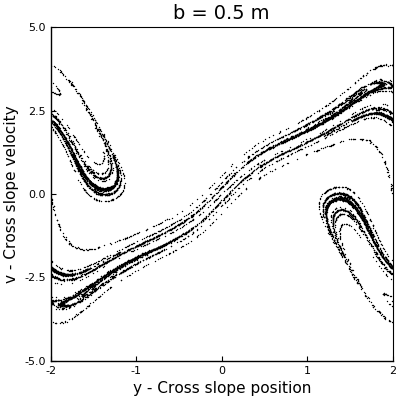

In [515]:
st = 1000
scatter(y_compact[:, st], v_compact[:, st], markersize = 1, legend=false, 
    markercolor= :black, grid = false, size =(400, 400), 
    markerstrokewidth=0, border = :box)
ylims!(-5,5)
xlims!(-2,2)
xlabel!("y - Cross slope position")
ylabel!("v - Cross slope velocity")
title!("b = 0.5 m")

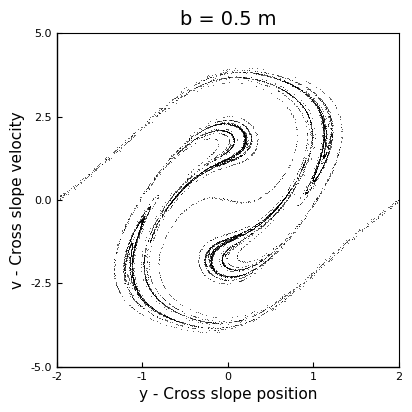

┌ Info: Saved animation to 
│   fn = /Users/claudiopierard/Projects/moguls_chaos/tmp.gif
└ @ Plots /Users/claudiopierard/.julia/packages/Plots/AXUqs/src/animation.jl:98


Plots.AnimatedGif("/Users/claudiopierard/Projects/moguls_chaos/tmp.gif")
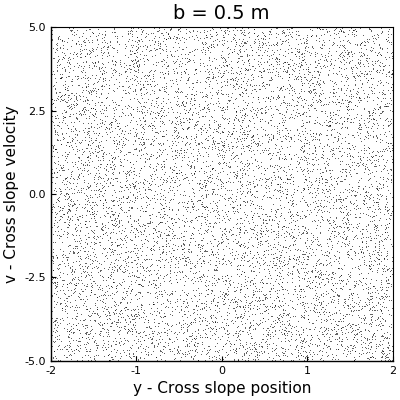

In [516]:
@gif for i=1:1500
    
    scatter(y_compact[:, i], v_compact[:, i], 
        markersize = 0.5, legend=false, 
        markercolor= :black, grid = false, 
        size =(400, 400), markerstrokewidth=0, border = :box)
    
    ylims!(-5,5)
    xlims!(-2,2)
    xlabel!("y - Cross slope position")
    ylabel!("v - Cross slope velocity")
    title!("b = 0.5 m")
    
end every 10

In [138]:
n_sleds = 8000
n_time = 5000
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds)*10 .- 5;

@time y_compact_02, v_compact_02 = sled_enssemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, 0.2)

  7.590253 seconds (13 allocations: 915.711 MiB)


([1.6202395071954676 1.647264170516376 … 1.5999867838467456 1.6169359232578175; 0.5580013116984484 0.5229266373806347 … -1.5999908346217278 -1.616940139334614; … ; 1.3795653217524482 1.4284901602422877 … 1.600024392978482 1.6169735393917046; 0.42181714741628884 0.3821293706959649 … -1.6000001480073598 -1.6169495681717416], [2.702466332090843 2.679284029781072 … 1.6949139411072003 1.7061036291896434; -3.5074674317813637 -3.5207297824870882 … -1.6949304712886109 -1.7061199679228038; … ; 4.892483848983948 4.862038174337616 … 1.694914641322259 1.7061029716267422; -3.968777672032391 -3.978255504189056 … -1.694942016438185 -1.7061311455996933])

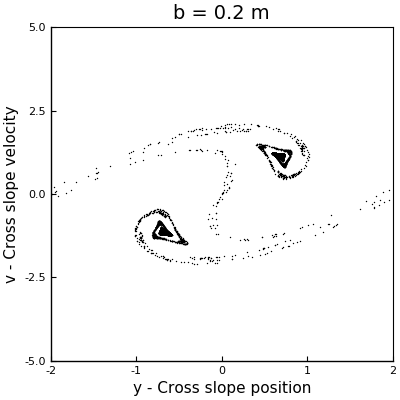

In [517]:
st = 1500
scatter(y_compact_02[:, st], v_compact_02[:, st], markersize = 1, legend=false, 
    markercolor= :black, grid = false, size =(400, 400), 
    markerstrokewidth=0, border = :box)
ylims!(-5,5)
xlims!(-2,2)
xlabel!("y - Cross slope position")
ylabel!("v - Cross slope velocity")
title!("b = 0.2 m")

# Routes from Chaos

Now we see that the attractor changes if we change the height of the bumps in the slope, the parameter $b$. Especially, we can think that when $b = 0$ m, the sled will follow straight lines, which are non-chaotic, and as we increase $b$ this trajectories will transition to chaotic ones. 

A practical way of visualizing this is by a bifurcation diagram, in which we plot the state of the system according to a parameter which drives the system.

In the sled case, we can use the local maximum cross slope velocity, deleting the transient states, to visualize were the sled has a periodic behavior or a chaotic one



In [580]:
b_range = collect(0:0.0005:0.7)
k_transient = 7100

n_sleds = 1
n_time = 7800
x_init = zeros(n_sleds) 
y_init = rand(n_sleds) .- 0.5
v_init = zeros(n_sleds)

orbit = Float64[]
b_par = Float64[]


for b_i in b_range
    
    y_tmp, v_tmp = sled_enssemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, b_i)
    
    v_tmp = v_tmp[:, k_transient:end]'
    v_tmp = reshape(v_tmp, length(v_tmp))
    
    for i in 2:length(v_tmp)-1
        
        if v_tmp[i] > v_tmp[i-1] && v_tmp[i] > v_tmp[i+1] || v_tmp[i] < v_tmp[i-1] && v_tmp[i] < v_tmp[i+1]
            
            append!(orbit, v_tmp[i])
            append!(b_par, b_i)
            
        end
    end
end

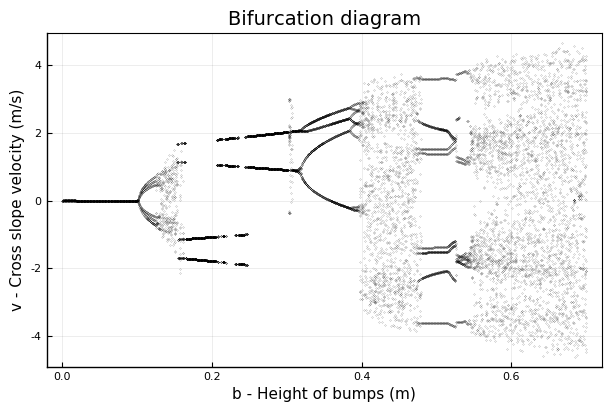

In [581]:
scatter(b_par, orbit, markersize=0.1, c=:black, leg=false, 
    xaxis=("b - Height of bumps (m)"), yaxis=("v - Cross slope velocity (m/s)"), border = :box)

title!("Bifurcation diagram")
savefig("fig/bifurcation_diagram_velocity")

We can see that there is axial symmetry with respect to $V = 0$ m/s. This means that the bifurcation diagram can be drawn in either the negative side of the velocities or the possitive side, creating regions without point in the lower and upper part. 

We can correct this is we consider only the cross slope speed, i.e. take the absolute value of $V$.

In [593]:
b_range = collect(0:0.0005:0.7)
k_transient = 7100

n_sleds = 1
n_time = 7800
x_init = zeros(n_sleds) 
y_init = rand(n_sleds) .- 0.5
println("y initial = ", y_init)
v_init = zeros(n_sleds)

orbit = Float64[]
b_par = Float64[]


for b_i in b_range
    
    y_tmp, v_tmp = sled_enssemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, b_i)
    
    v_tmp = v_tmp[:, k_transient:end]'
    v_tmp = reshape(v_tmp, length(v_tmp))
    
    for i in 2:length(v_tmp)-1
        
        if v_tmp[i] > v_tmp[i-1] && v_tmp[i] > v_tmp[i+1] || v_tmp[i] < v_tmp[i-1] && v_tmp[i] < v_tmp[i+1]
            
            append!(orbit, abs(v_tmp[i]))
            append!(b_par, b_i)
            
        end
    end
end

y initial = [0.17150423310288798]


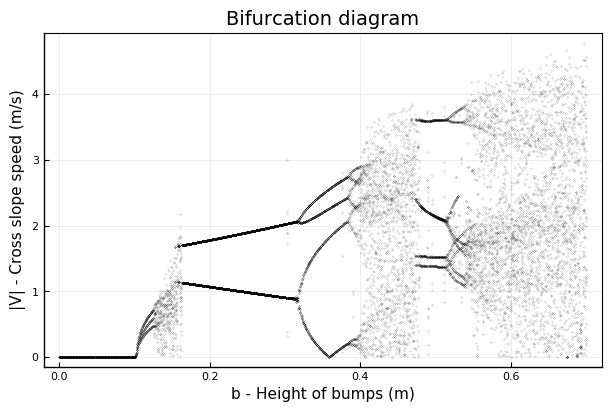

In [594]:
scatter(b_par, orbit, markersize=0.1, c=:black, leg=false, 
    xaxis=("b - Height of bumps (m)"), yaxis=("|V| - Cross slope speed (m/s)"), border = :box)

title!("Bifurcation diagram")
savefig("fig/bifurcation_diagram_speed")

The regions with clouds of points are the chaotic ones. The regionswhere there are only lines, indicate states in which the sled reaches an periodic trajectory. Is possible to see that from 0.4 the sled trajectories are chaotic, with an apparent periodicity between $b = 0.5$ m and $b = 0.6$ m. Althogh, this bifurcation diagrams are higly dependent in the initial condition given, and they may change according to this.
